# Inference code - Using Trained Models for Activity Recognition of Test Videos

This is a notebook to use the trained Keras models to predict the class of activity in a video.

Using this notebook we can choose a video included in the "*example*" directory and generate the class of activity it belongs to.

The activity class set is restricted to the following 10 types:

{'BoxingPunchingBag', 'CricketShot', 'Drumming', 'HorseRiding', 'PlayingCello', 'PlayingDhol', 'PlayingGuitar', 'Punch', 'ShavingBeard', 'TennisSwing'}

In the "*example*" directory 2 videos of each class is already provided. These are sampled from the test set of our dataset. Hence, these are unseen data that are fed into the model.

<mark>**Note**: This inference code does not test the ORB feature trained model as it shows poor learning and performnce metrices even when a large model is used. </mark> Although this can be very easilt extended to use the models as well by including the code to load the ORB keypoint extractor and descriptor. 

## Install, Download and Import

1. Install some libraries and tools.

2. Download the models that we will use to predict the output of the acitivity in a video.

3. Download a small directory of videos sampled from the test videos (hence, unseen data i.e. not used to train the model) for testing.

4. Import the required libraries. We have imported the method **plot_model** from **keras.utils.vis_utils** to visualize the models that are loaded.

In [1]:
#install libraries
!pip uninstall tensorflow
!pip install tensorflow=='2.7.0'
!pip install -q git+https://github.com/tensorflow/docs
!pip install transformers
!pip install gdown

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.9/dist-packages/tensorflow-2.7.0.dist-info/*
    /usr/local/lib/python3.9/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.7.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.7.0-cp39-cp39-manylinux2010_x86_64.whl (489.7 MB)
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#download models
!gdown 1KYffjYz7SDSx-Vviw7I8UX5KCgTE79KR      #CNN-GRU
!gdown 1t4BUVZcY5cca9s-YSNy_Np2UuNwUn2v4      #DeIT-GRU

#unarchive
!tar -xf activity_recog_cnn_gru.tgz
!tar -xf activity_recog_deit_gru.tgz

Downloading...
From: https://drive.google.com/uc?id=1KYffjYz7SDSx-Vviw7I8UX5KCgTE79KR
To: /content/activity_recog_cnn_gru.tgz
100% 15.6M/15.6M [00:00<00:00, 132MB/s]
Downloading...
From: https://drive.google.com/uc?id=1t4BUVZcY5cca9s-YSNy_Np2UuNwUn2v4
To: /content/activity_recog_deit_gru.tgz
100% 9.71M/9.71M [00:00<00:00, 142MB/s]


In [3]:
#download test data
!gdown 1lukA6aljqIo59-modLUjofRE6EYnP2d9

#unarchive
!tar -xf example.tgz

Downloading...
From: https://drive.google.com/uc?id=1lukA6aljqIo59-modLUjofRE6EYnP2d9
To: /content/example.tgz
100% 11.4M/11.4M [00:00<00:00, 142MB/s]


In [4]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
from tqdm import tqdm

from transformers import AutoFeatureExtractor, DeiTForImageClassificationWithTeacher
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

## Load the trained Keras models

Now that we have downloaded the trained models for video recognition we can load the models and display the architecture.

As mentioned in the previous section, we use the method **plot_model** from **keras.utils.vis_utils** to visualize these models.

The *show_shapes* and *show_layer_names* parameters enables the display of layer I/O shapes and the layer names, respectively. The *rankdir* parameter is used to determine the direction of the plot i.e. 'LR' for left-to-right or horizontal and 'TB' (default) for top-to-bottom or vertical.

This method will generate a file (given by the *to_file* parameter) where the plot will be saved.

In [5]:
cnn_gru_model = keras.models.load_model('/content/activity_recog_cnn_gru')
deit_gru_model= keras.models.load_model('/content/activity_recog_deit_gru')

In [6]:
plot_model(cnn_gru_model, to_file='cnn_gru_viz.pdf', show_shapes=True, show_layer_names=True, rankdir='TB')

In [7]:
plot_model(deit_gru_model, to_file='deit_gru_viz.pdf', show_shapes=True, show_layer_names=True, rankdir='TB')

## Define the feature extractor and the label mapping

We just use the feature extractors that were defined in the respective training notebooks. *Please check these notebooks for more details.*

Notice that the model trained using features extracted using DeIT and that trained using Inception Net V3 (CNN) expect different shapes of input. Particularly, the latter expects 20 frames to be sampled compared to 5 and explicitly requires a hyper-parameter for image size. Also, the feature vectors extracted are of different shapes i.e. 2048 o the CNN-based model compared to 768 of the DeIT-based model. Hence, that needs to be taken care of.

In [8]:
#CNN-based model specific hyper-parameters
IMG_SIZE = 224
CNN_MAX_SEQ_LENGTH = 20
CNN_NUM_FEATURES = 2048

#DeIT-based model specific hyper-parameters
DeIT_MAX_SEQ_LENGTH = 5
DeIT_NUM_FEATURES = 768

In [9]:
#CNN-based model feature extractor
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


cnn_feature_extractor = build_feature_extractor()

In [10]:
#load the pre-trained model and init the feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-224')
deit_model = DeiTForImageClassificationWithTeacher.from_pretrained('facebook/deit-base-distilled-patch16-224')

/usr/local/lib/python3.9/dist-packages/transformers/models/deit/feature_extraction_deit.py:28: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(


In [11]:
#define the hook callable
activation = {}

def getActivation(name):
    # the hook signature
    def hook(model, input, output):
      try:
        activation[name] = output.detach()
      except:
        activation[name] = output
    return hook

#attach hooks to get intermediate activation
deit_encoder = deit_model.deit.register_forward_hook(getActivation('deit_encoder'))

In [12]:
#DeIT-based model feature extractor
def deit_feature_extractor(image):
  inputs = feature_extractor(images=image, return_tensors="pt")
  outputs = deit_model(**inputs)

  feature = activation['deit_encoder'][0][ : , 0, : ].detach().numpy()
  return feature

In [13]:
class_lookup = ['BoxingPunchingBag', 'CricketShot', 'Drumming', 'HorseRiding', 'PlayingCello', 'PlayingDhol', 'PlayingGuitar', 'Punch', 'ShavingBeard', 'TennisSwing']

## Define method to process frames and generate predictions

This is again taken directly from the *Inference* section of the respective training notebooks. *Please check these notebooks for more details.*

A slight modeification to the *load_video* method has been done to keep it common for both CNN-based model and DeIT-based model. A flag has been introduced that if set to **True** (default) loads the video as per the requirement of the CNN-based model and resizes the frames and inverts the BGR channel order to RGB. 

The same type of modification is also made in the *sequence_prediction* method that puts everything together and gives the prediction of the activity. Here, we have added the functionality to genrate the predictions using both the models.

The 2 models have different methods to process frames (as expected) due to different feature extracters being used. We keep them seperate for better comprehensibility of code. 

In [14]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE), load_per_cnn = True):
    cap = cv2.VideoCapture(path)
    F = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))    #total number of frames in the video
    M = max_frames                                #max sequence length required
    S = max(int(np.floor(F/M)), 1)                #in case step-size goes to 0

    frames = []
    frame_count = 0
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count%S == 0:                #sample only at steps
              frame = crop_center_square(frame)
              if load_per_cnn:
                frame = cv2.resize(frame, resize)
                frame = frame[:, :, [2, 1, 0]]
              frames.append(frame)

            frame_count += 1                      #update number of frames read
            
            #break if we reach end of video or maximum required frames read  
            if frame_count==F or len(frames) == M:         
                break
    finally:
        cap.release()
    return np.array(frames)

In [15]:
#processing video frames for CNN-based model
def cnn_prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, CNN_MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, CNN_MAX_SEQ_LENGTH, CNN_NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        length = batch.shape[0]
        assert length == CNN_MAX_SEQ_LENGTH, "sequence length not sufficient!"
        for j in range(length):
            frame_features[i, j, :] = cnn_feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

In [16]:
#processing video frames for DeIT-based model
def deit_prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, DeIT_MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, DeIT_MAX_SEQ_LENGTH, DeIT_NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        length = batch.shape[0]
        assert length == DeIT_MAX_SEQ_LENGTH, "sequence length not sufficient!"
        for j in range(length):
          frame_features[i, j, :] = deit_feature_extractor(batch[j, :])
        
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

In [17]:
#sequence prediction method
def sequence_prediction(path):

    assert os.path.exists(path) and os.path.isfile(path), "path does not exist or is not a file!"

    #CNN model based predictions
    cnn_frames = load_video(path, max_frames=CNN_MAX_SEQ_LENGTH)
    cnn_frame_features, cnn_frame_mask = cnn_prepare_single_video(cnn_frames)
    cnn_probabilities = cnn_gru_model.predict([cnn_frame_features, cnn_frame_mask])[0]

    #DeIT model based predictions
    deit_frames = load_video(path, max_frames=DeIT_MAX_SEQ_LENGTH, load_per_cnn=False)
    deit_frame_features, deit_frame_mask = deit_prepare_single_video(deit_frames)
    deit_probabilities = deit_gru_model.predict([deit_frame_features, deit_frame_mask])[0]

    print("-----InceptionNetV3-----")
    for i in np.argsort(cnn_probabilities)[::-1]:
        print(f"  {class_lookup[i]}: {cnn_probabilities[i] * 100:5.2f}%")

    print("-----DeIT-----")
    for i in np.argsort(deit_probabilities)[::-1]:
        print(f"  {class_lookup[i]}: {deit_probabilities[i] * 100:5.2f}%")

    return cnn_frames

## Choose a video from example and predict activity

We randomly choose any video from the *example* directory and predict its class.

We use the frames used by CNN to create a gif just for the sake of illustration.

In [18]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

Testing : /content/example/v_Punch_g03_c01.avi
-----InceptionNetV3-----
  Punch: 99.99%
  TennisSwing:  0.00%
  BoxingPunchingBag:  0.00%
  ShavingBeard:  0.00%
  PlayingCello:  0.00%
  PlayingGuitar:  0.00%
  Drumming:  0.00%
  CricketShot:  0.00%
  PlayingDhol:  0.00%
  HorseRiding:  0.00%
-----DeIT-----
  Punch: 99.99%
  TennisSwing:  0.00%
  PlayingDhol:  0.00%
  Drumming:  0.00%
  HorseRiding:  0.00%
  PlayingGuitar:  0.00%
  CricketShot:  0.00%
  ShavingBeard:  0.00%
  BoxingPunchingBag:  0.00%
  PlayingCello:  0.00%



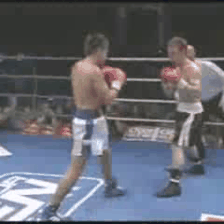

In [19]:
ex_dir = '/content/example'

###########################################################
file_lst = os.listdir(ex_dir)
ex_vid_name = file_lst[np.random.randint(0, len(file_lst))]
###########################################################

#if you are testing on specific video, comment out the lines marked above
#and provide full path in the variable below
ex_vid_path = os.path.join(ex_dir, ex_vid_name)

print(f'Testing : {ex_vid_path}')

frames = sequence_prediction(ex_vid_path)
to_gif(frames)                     